## Classification on credit-g dataset
This code includes my answers to the first part of homework 2 of Andreas Muller's course, Applied Machine Learning, Spring 2020 at Columbia (https://www.cs.columbia.edu/~amueller/comsw4995s20/schedule/). 
- The dataset for classification part can be donwloaded with "fetch_openml('credit_g')" and its description can be found at https://www.openml.org/d/31.
German Credit data: This dataset classifies people described by a set of attributes as good or bad credit risks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold, ShuffleSplit, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet, LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder, MaxAbsScaler, Normalizer, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC 
from sklearn.impute import SimpleImputer

from sklearn.datasets import fetch_openml

## Classification on credit-g dataset
**1.**
Read the data file and find the features.

In [2]:
creditg = fetch_openml('credit-g')

In [3]:
df = pd.DataFrame(creditg['data'], columns=creditg['feature_names'])

In [4]:
df['target'] = creditg['target']

In [5]:
features = ['duration', 'credit_amount', 'installment_commitment','residence_since','age','existing_credits','num_dependents','checking_status','credit_history','purpose','savings_status','employment','personal_status','other_parties','property_magnitude','other_payment_plans','housing','job','own_telephone','foreign_worker']

**1.1.**
Determine which features are continuous and which are categorical, using the features detail on the website.

In [6]:
features_cont = ['duration', 'credit_amount', 'installment_commitment','residence_since','age','existing_credits','num_dependents']

In [7]:
features_cat = ['checking_status','credit_history','purpose','savings_status','employment','personal_status','other_parties','property_magnitude','other_payment_plans','housing','job','own_telephone','foreign_worker']

**1.2.**
Visualize the univariate distribution of each continuous feature, and the distribution of the target.

In [11]:
df['target_ordinal']=df.target.astype("category").cat.codes

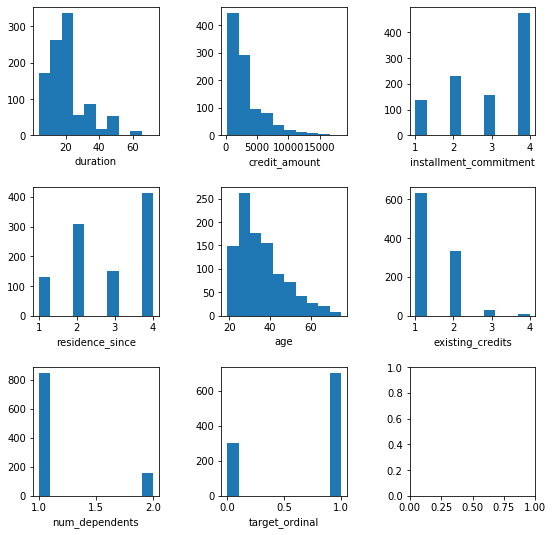

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

axes[0,0].hist(df['duration'])
axes[0,0].set_xlabel('duration')

axes[0,1].hist(df['credit_amount'])
axes[0,1].set_xlabel('credit_amount')

axes[0,2].hist(df['installment_commitment'])
axes[0,2].set_xlabel('installment_commitment')

axes[1,0].hist(df['residence_since'])
axes[1,0].set_xlabel('residence_since')

axes[1,1].hist(df['age'])
axes[1,1].set_xlabel('age')

axes[1,2].hist(df['existing_credits'])
axes[1,2].set_xlabel('existing_credits')

axes[2,0].hist(df['num_dependents'])
axes[2,0].set_xlabel('num_dependents')

axes[2,1].hist(df['target_ordinal'])
axes[2,1].set_xlabel('target_ordinal')

plt.subplots_adjust(hspace=0.4, wspace=0.5)

**1.3.**
Split data into training and test set. Do not use the test set until a final evaluation in 1.5.
Preprocess the data (such as treatment of categorical variables) without using a pipeline and
evaluate an initial LogisticRegression model with a training/validation split.

In [16]:
for feature in features_cat:
    print(feature, len(df[feature].value_counts()))

checking_status 4
credit_history 5
purpose 10
savings_status 5
employment 5
personal_status 4
other_parties 3
property_magnitude 4
other_payment_plans 3
housing 3
job 4
own_telephone 2
foreign_worker 2


In [17]:
for feature in features_cat:
    df[feature] = df[feature].astype("category").cat.codes

In [21]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df[features], df['target_ordinal'], random_state=0)

In [22]:
X_trainval_treat = pd.get_dummies(X_trainval, columns=features_cat)

In [23]:
lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
score = cross_val_score(lr, X_trainval_treat, y_trainval, cv=10)
print(np.mean(score), np.std(score))

0.748 0.037452191747168365


**1.4.**
Use ColumnTransformer and Pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate
Logistic Regression, linear support vector machines and nearest neighbors using
cross-validation. How different are the results? How does scaling the continuous features with
StandardScaler influence the results?

### Logistic Regression

In [26]:
prep = make_column_transformer((StandardScaler(), features_cont), (OneHotEncoder(categories='auto'), features_cat), remainder='passthrough')

pipe_lr = make_pipeline(prep, LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))

score = cross_val_score(pipe_lr, X_trainval, y_trainval, cv=10)
print(np.mean(score), np.std(score))

0.7626666666666668 0.040353989201124166


### Linear SVM

In [27]:
pipe_svm = make_pipeline(prep, LinearSVC(random_state=0, max_iter=100000))

score_svm = cross_val_score(pipe_svm, X_trainval, y_trainval, cv=10)
print(np.mean(score_svm), np.std(score_svm))

0.7533333333333334 0.049261208538429795


### K Nearest Neighbors 

In [28]:
pipe_knn = make_pipeline(prep, KNeighborsClassifier())

score_knn = cross_val_score(pipe_knn, X_trainval, y_trainval, cv=10)
print(np.mean(score_knn), np.std(score_knn))

0.732 0.036


**1.5.**
Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the best
model on the test set.
Visualize the performance as function of the parameters for all three models.

### Logistic Regression with GridSearchCv

In [29]:
X_train_clean = prep.fit_transform(X_trainval)

lr_param_grid = {'C': np.logspace(-4, 0, 10)}
lr_grid = GridSearchCV(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000), lr_param_grid, cv=10)
lr_grid.fit(X_train_clean, y_trainval)

print('LogisticRegression Best Parameter:', lr_grid.best_params_)
print('LogisticRegression Best Score:', lr_grid.best_score_)

LogisticRegression Best Parameter: {'C': 1.0}
LogisticRegression Best Score: 0.7626666666666668


### Linear SVM with GridSearchCv

In [30]:
svm_param_grid = {'C': np.logspace(-4, 0, 10)}
svm_grid = GridSearchCV(LinearSVC(random_state=0, max_iter=100000), svm_param_grid, cv=10)
svm_grid.fit(X_train_clean, y_trainval)

print('LinearSVC Best Parameter:', svm_grid.best_params_)
print('LinearSVC Best Score:', svm_grid.best_score_)

LinearSVC Best Parameter: {'C': 0.12915496650148828}
LinearSVC Best Score: 0.7626666666666667


### K Nearest Neighbors with GridSearchCv

In [31]:
knn_param_grid = {'n_neighbors': [1, 5, 10, 15]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10)
knn_grid.fit(X_train_clean, y_trainval)

print('KNeighborsClassifier Best Parameter:', knn_grid.best_params_)
print('KNeighborsClassifier Best Score:', knn_grid.best_score_)

KNeighborsClassifier Best Parameter: {'n_neighbors': 10}
KNeighborsClassifier Best Score: 0.7386666666666666


### The best model: Linear SVM

In [33]:
X_test_clean = prep.transform(X_test)

best_model = LinearSVC(random_state=0, max_iter=100000, C=0.129)
best_model.fit(X_train_clean, y_trainval)


best_model.score(X_test_clean, y_test)

0.736

### Visualizing the model performance vs parameters

In [34]:
lr_results = lr_grid.cv_results_
lr_params = lr_param_grid['C']
lr_mean_scores = lr_results['mean_test_score']

svm_results = svm_grid.cv_results_
svm_params = svm_param_grid['C']
svm_mean_scores = svm_results['mean_test_score']

knn_results = knn_grid.cv_results_
knn_params = knn_param_grid['n_neighbors']
knn_mean_scores = knn_results['mean_test_score']

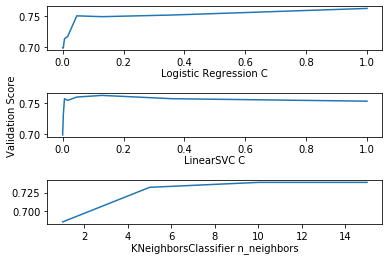

In [35]:
fig, ax = plt.subplots(3, 1)

ax[0].plot(lr_params, lr_mean_scores)
ax[0].set_xlabel('Logistic Regression C', labelpad = 1)
#ax[0].set_ylabel('Validation Score', labelpad = 1)

ax[1].plot(svm_params, svm_mean_scores)
ax[1].set_xlabel('LinearSVC C', labelpad = 1)
ax[1].set_ylabel('Validation Score', labelpad = 1)

ax[2].plot(knn_params, knn_mean_scores)
ax[2].set_xlabel('KNeighborsClassifier n_neighbors', labelpad = 1)
#ax[2].set_ylabel('Validation Score', labelpad = 1)

plt.subplots_adjust(hspace=1)


**1.6.**
Change the cross-validation strategy from 'stratified k-fold' to 'kfold' with shuffling. Do the
parameters that are found change? Do they change if you change the random seed of the
shuffling? Or if you change the random state of the split into training and test data

In [48]:
kf = KFold(n_splits=100, shuffle=True, random_state=0)

In [49]:
#change cv=10 to cv=kf

lr_param_grid = {'C': np.logspace(-4, 0, 10)}
lr_grid = GridSearchCV(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000), lr_param_grid, cv=kf)
lr_grid.fit(X_train_clean, y_trainval)

print('LogisticRegression Best Parameter:', lr_grid.best_params_)
print('LogisticRegression Best Score:', lr_grid.best_score_)

svm_param_grid = {'C': np.logspace(-4, 0, 10)}
svm_grid = GridSearchCV(LinearSVC(random_state=0, max_iter=100000), svm_param_grid, cv=kf)
svm_grid.fit(X_train_clean, y_trainval)

print('LinearSVC Best Parameter:', svm_grid.best_params_)
print('LinearSVC Best Score:', svm_grid.best_score_)

knn_param_grid = {'n_neighbors': [1, 5, 10, 15]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=kf)
knn_grid.fit(X_train_clean, y_trainval)

print('KNeighborsClassifier Best Parameter:', knn_grid.best_params_)
print('KNeighborsClassifier Best Score:', knn_grid.best_score_)

LogisticRegression Best Parameter: {'C': 0.046415888336127774}
LogisticRegression Best Score: 0.7562499999999999
LinearSVC Best Parameter: {'C': 0.016681005372000592}
LinearSVC Best Score: 0.7580357142857141
KNeighborsClassifier Best Parameter: {'n_neighbors': 15}
KNeighborsClassifier Best Score: 0.7448214285714285


So yes, changing the CV to kf instead of 10-fold cross validation changes the parameters, but not significantly the scores. Also changing the random_state in kf changes the parametrs.

**1.7.**
Visualize the 20 most important coefficients for LogisticRegression and Linear Support
Vector Machines using hyper-parameters that performed well in the grid-search.

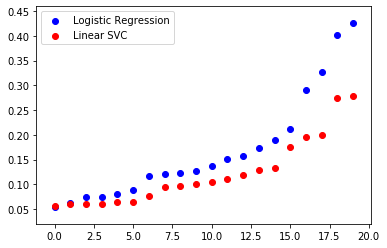

In [50]:
lr_coef = lr_grid.best_estimator_.coef_
svm_coef = svm_grid.best_estimator_.coef_

lr_coef.sort()
svm_coef.sort()

param_important = range(0,20)

fig, ax = plt.subplots(1,1)
ax1 = plt.gca()

ax1.scatter(param_important, lr_coef[0][len(lr_coef[0])-21:len(lr_coef[0])-1], color='b', label='Logistic Regression')
ax1.scatter(param_important, svm_coef[0][len(svm_coef[0])-21:len(svm_coef[0])-1], color='r', label='Linear SVC')

ax1.legend()